# EDA: FER2013 and RAVDESS

This notebook performs a detailed exploratory data analysis (EDA) for the FER2013 (facial images) and RAVDESS (speech audio) datasets. It inspects file counts, class distributions, sample images and audio, audio duration statistics, MFCC shapes, missing/corrupted files, and saves plots and summary CSVs to `outputs/results/eda/`.

In [1]:
# 1) Import required libraries
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import librosa
import soundfile as sf
from IPython.display import Audio, display
from tqdm.auto import tqdm

sns.set(style='whitegrid')
%matplotlib inline

# Print environment info
print('Working directory:', os.getcwd())
print('FER dir exists:', os.path.exists('data/fer2013'))
print('RAVDESS dir exists:', os.path.exists('data/ravdess'))


Working directory: c:\Users\ITSolutions\Desktop\Multimodal-Emotion-Recognition\notebooks
FER dir exists: False
RAVDESS dir exists: False


In [2]:
# Ensure notebook is running from repository root
import os
from pathlib import Path
repo_root = Path.cwd().parent if (Path.cwd() / '..').exists() else Path.cwd()
# If notebook is inside notebooks/, move up one level to repo root
if Path.cwd().name == 'notebooks':
    os.chdir(str(Path.cwd().parent))

print('New working directory:', os.getcwd())
print('FER exists now:', Path('data/fer2013').exists())
print('RAVDESS exists now:', Path('data/ravdess').exists())

New working directory: c:\Users\ITSolutions\Desktop\Multimodal-Emotion-Recognition
FER exists now: True
RAVDESS exists now: True


In [3]:
# Helper: ensure output directory
out_dir = Path('outputs/results/eda')
out_dir.mkdir(parents=True, exist_ok=True)

# Helper functions

def load_image(path):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return img


def plot_image_grid(images, titles=None, ncols=5, cmap='gray', figsize=(12,8), save=None):
    n = len(images)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < n:
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')
            if titles is not None:
                ax.set_title(titles[i], fontsize=9)
        else:
            ax.axis('off')
    plt.tight_layout()
    if save:
        fig.savefig(save, dpi=200, bbox_inches='tight')
    return fig


def safe_load_audio(path):
    try:
        data, sr = sf.read(path)
        return data, sr
    except Exception as e:
        try:
            data, sr = librosa.load(path, sr=None)
            return data, sr
        except Exception:
            return None, None


def extract_mfcc(y, sr, n_mfcc=40, max_len=100):
    if y is None:
        return None
    mfcc = librosa.feature.mfcc(y=y.astype(float), sr=sr, n_mfcc=n_mfcc)
    # pad/truncate
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc


## Load both datasets (file inspection)

We'll inspect the file structure for `data/fer2013` and `data/ravdess` and create DataFrames summarizing counts per class/actor.

FER2013 class counts (train/test):
split     test  train
class                
angry      958   3995
disgust    111    436
fear      1024   4097
happy     1774   7215
neutral   1233   4965
sad       1247   4830
surprise   831   3171


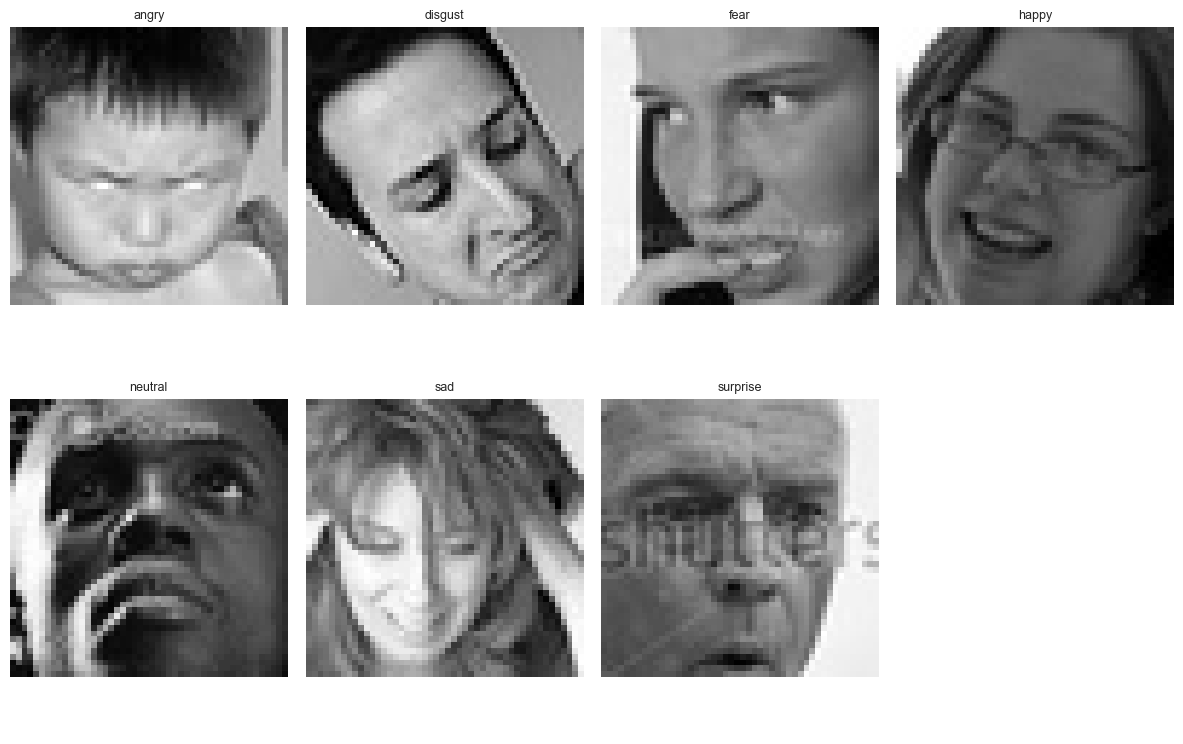

In [4]:
# FER2013 file inspection
fer_root = Path('data/fer2013')
fer_train = fer_root / 'train'
fer_test = fer_root / 'test'

fer_counts = []
for split in ['train','test']:
    split_dir = fer_root / split
    if split_dir.exists():
        for cls_dir in sorted(split_dir.glob('*')):
            if cls_dir.is_dir():
                cnt = len(list(cls_dir.glob('*')))
                fer_counts.append({'split': split, 'class': cls_dir.name, 'count': cnt})
fer_df = pd.DataFrame(fer_counts)
fer_df_pivot = fer_df.pivot(index='class', columns='split', values='count').fillna(0).astype(int)

print('FER2013 class counts (train/test):')
print(fer_df_pivot)
fer_df_pivot.to_csv(out_dir / 'fer_class_counts.csv')

# show a few samples for each class
sample_images = []
sample_titles = []
for cls in sorted((fer_train).glob('*')):
    if cls.is_dir():
        files = list(cls.glob('*'))
        if files:
            img = load_image(files[0])
            sample_images.append(img)
            sample_titles.append(cls.name)

fig = plot_image_grid(sample_images, titles=sample_titles, ncols=4, save=out_dir / 'fer_sample_grid.png')
plt.show()


## FER2013: Distribution and statistical summary

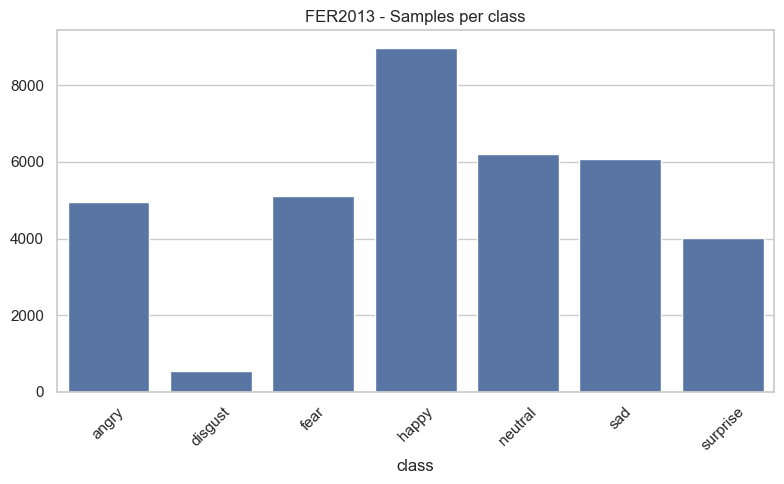

Unique image shapes (sample): [(48, 48)]
Mean pixel value (sample mean): 128.79103081597222


In [5]:
# Class distribution plot
if not fer_df.empty:
    plt.figure(figsize=(8,5))
    sns.barplot(x=fer_df.groupby('class')['count'].sum().index, y=fer_df.groupby('class')['count'].sum().values)
    plt.xticks(rotation=45)
    plt.title('FER2013 - Samples per class')
    plt.tight_layout()
    plt.savefig(out_dir / 'fer_class_distribution.png', dpi=200)
    plt.show()

# Check image sizes and pixel statistics on a small sample
image_shapes = []
pixel_means = []
for p in list((fer_root/'train').glob('*/*'))[:200]:
    img = load_image(p)
    if img is None:
        continue
    image_shapes.append(img.shape)
    pixel_means.append(img.mean())

print('Unique image shapes (sample):', pd.Series(image_shapes).unique()[:10])
print('Mean pixel value (sample mean):', np.mean(pixel_means))

pd.Series(image_shapes).value_counts().to_csv(out_dir / 'fer_image_shapes_sample.csv')


## RAVDESS: File inspection, per-actor and per-emotion counts

Total RAVDESS wav files found: 2880


  0%|          | 0/2880 [00:00<?, ?it/s]

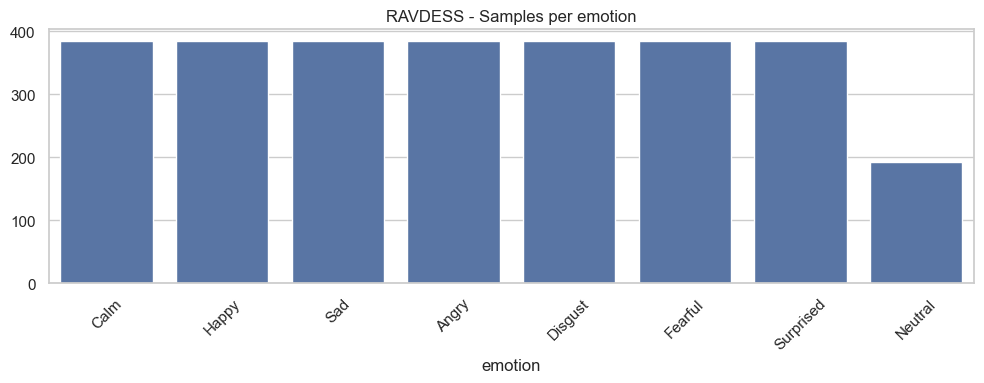

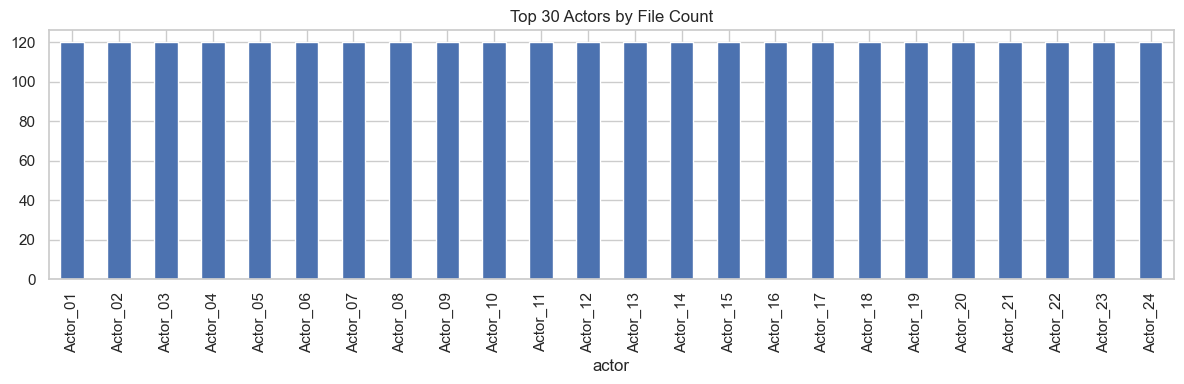

Failed audio file parses: 0


In [6]:
# RAVDESS inspection
rav_root = Path('data/ravdess')
# find wav files inside any actor subfolders
wav_files = list(rav_root.rglob('*.wav'))

print('Total RAVDESS wav files found:', len(wav_files))

# parse filenames to get emotion and actor
# Known RAVDESS filename structure (example): '03-01-01-01-01-01-01.wav'
# Field 3 is emotion (1..8); we'll map to labels
emotion_map = {
    '01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad',
    '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'
}

rows = []
failed_files = []
for p in tqdm(wav_files):
    try:
        parts = p.stem.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = emotion_map.get(emotion_code, 'Unknown')
        else:
            emotion = 'Unknown'
        # actor may be in parent folder name or last fields
        actor = p.parent.name
        rows.append({'path': str(p), 'emotion': emotion, 'actor': actor})
    except Exception as e:
        failed_files.append(str(p))

rav_df = pd.DataFrame(rows)
if not rav_df.empty:
    per_emotion = rav_df['emotion'].value_counts()
    per_actor = rav_df['actor'].value_counts()
    per_emotion.to_csv(out_dir / 'rav_per_emotion.csv')
    per_actor.to_csv(out_dir / 'rav_per_actor.csv')

    plt.figure(figsize=(10,4))
    sns.barplot(x=per_emotion.index, y=per_emotion.values)
    plt.title('RAVDESS - Samples per emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_dir / 'rav_emotion_distribution.png', dpi=200)
    plt.show()

    plt.figure(figsize=(12,4))
    per_actor.head(30).plot(kind='bar')
    plt.title('Top 30 Actors by File Count')
    plt.tight_layout()
    plt.savefig(out_dir / 'rav_top_actors.png', dpi=200)
    plt.show()

print('Failed audio file parses:', len(failed_files))


## RAVDESS: Audio durations, waveform and spectrogram examples

Audio duration stats: count= 2880 mean= 3.7006648148148145 std= 0.3365587103688152


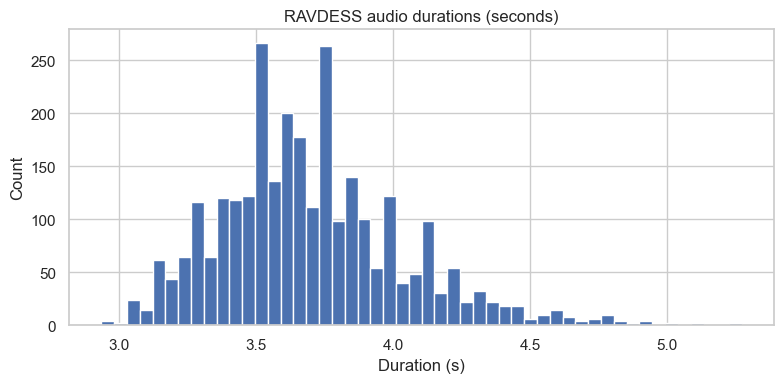

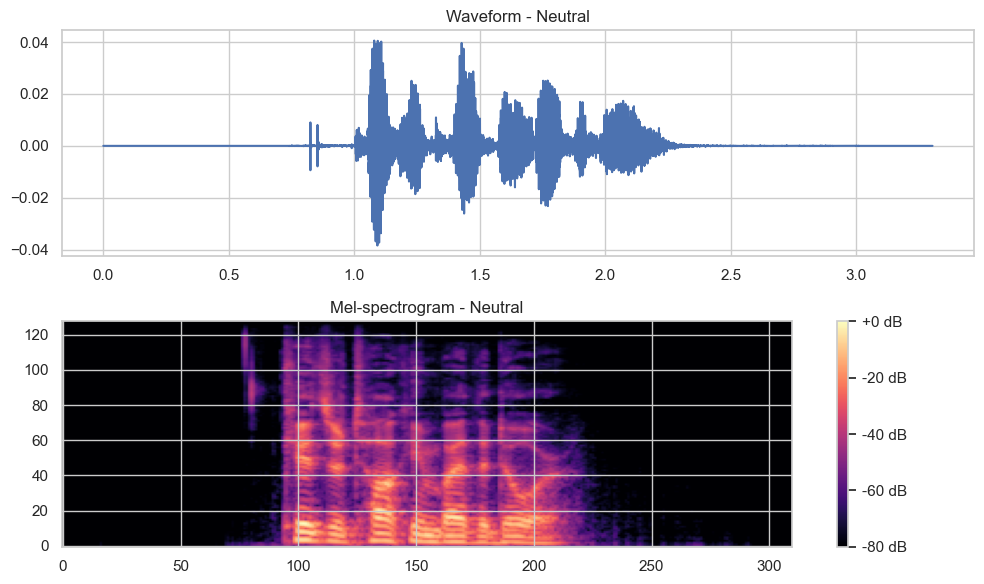

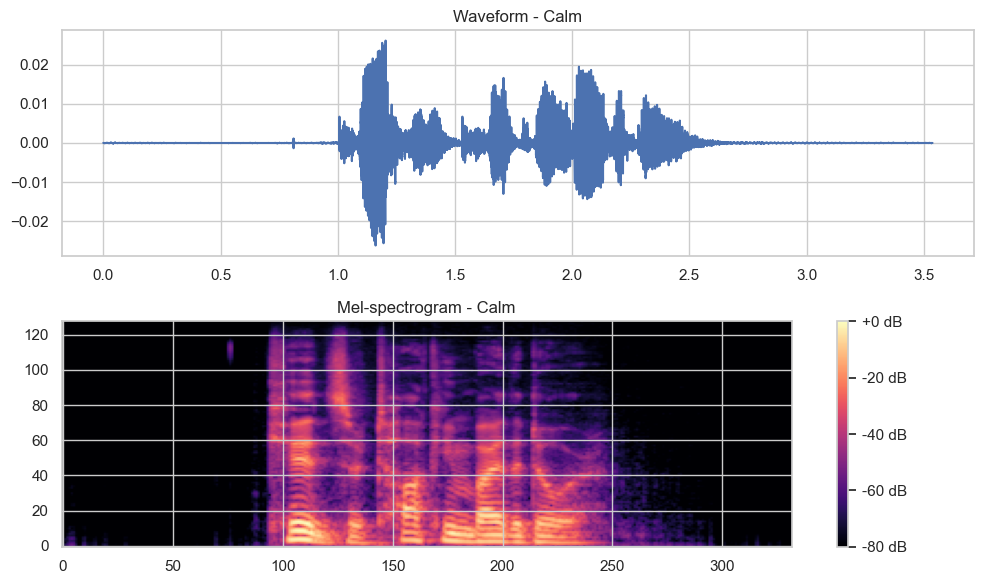

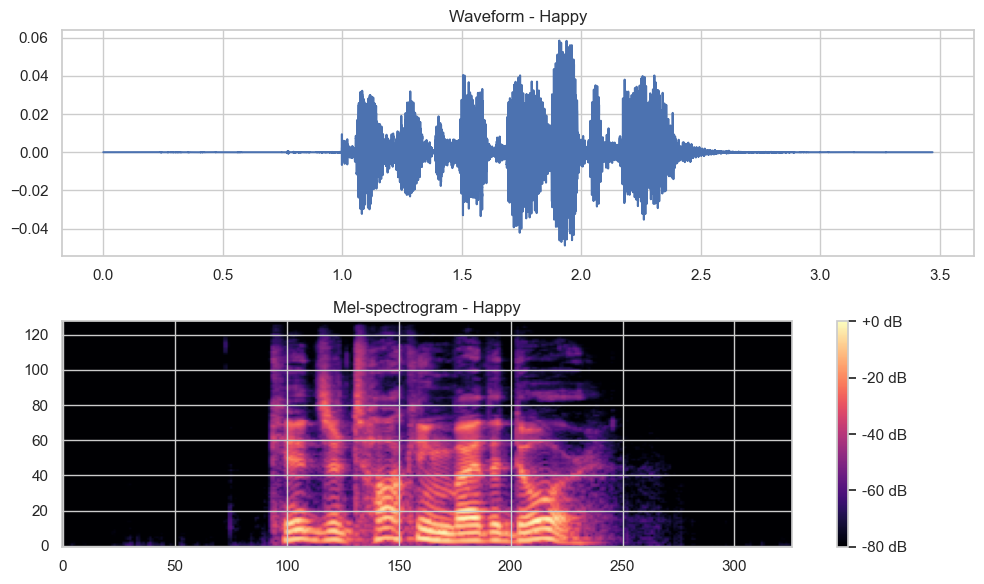

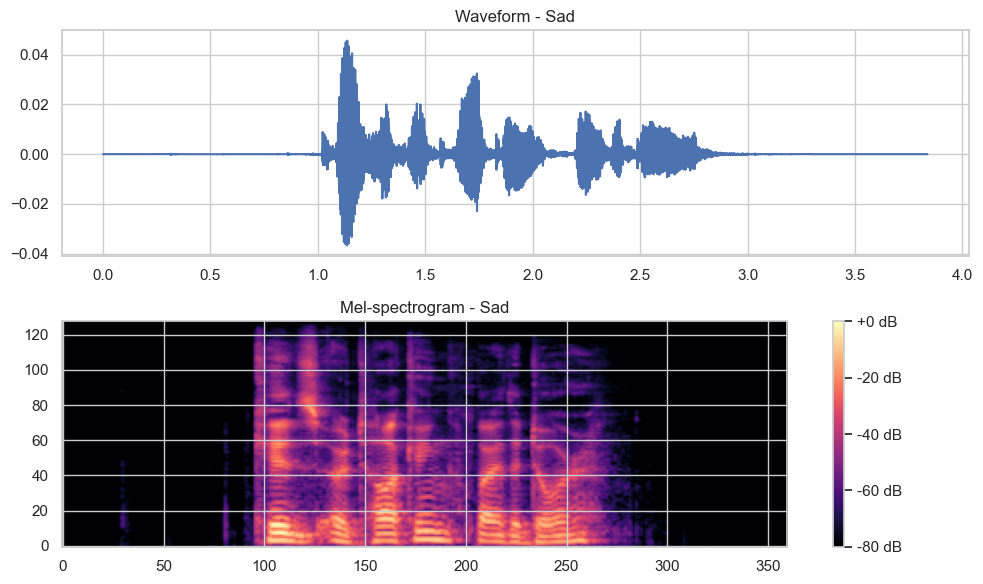

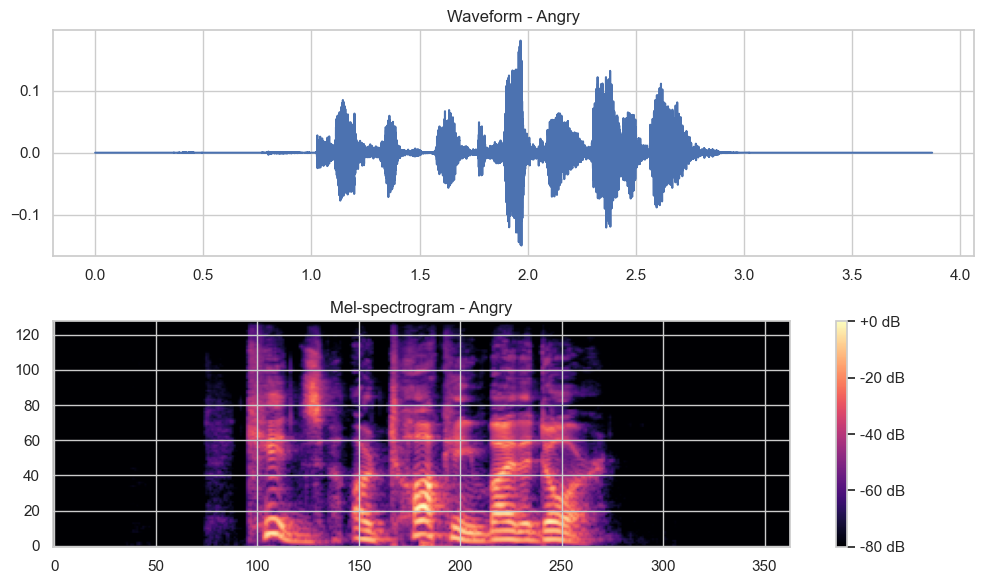

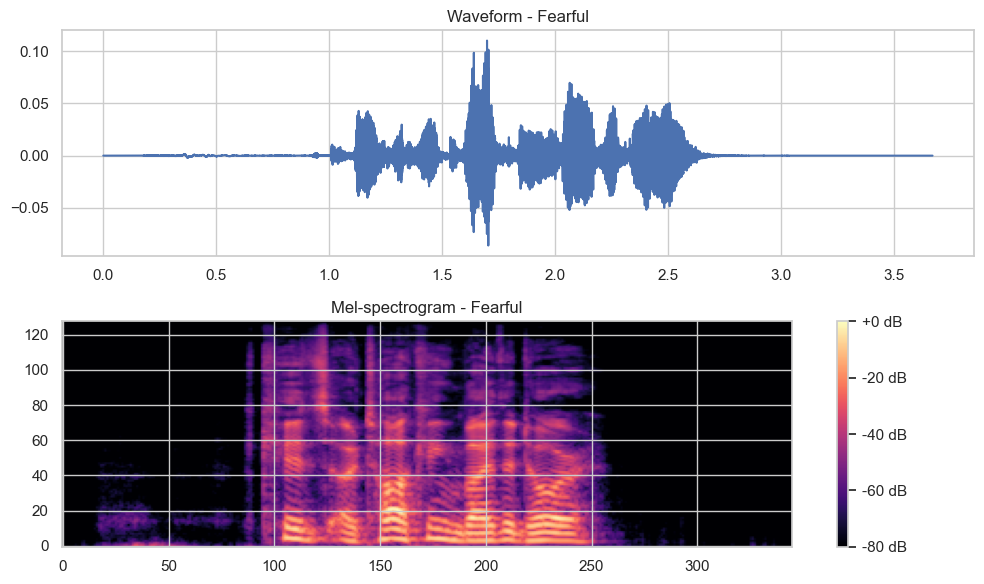

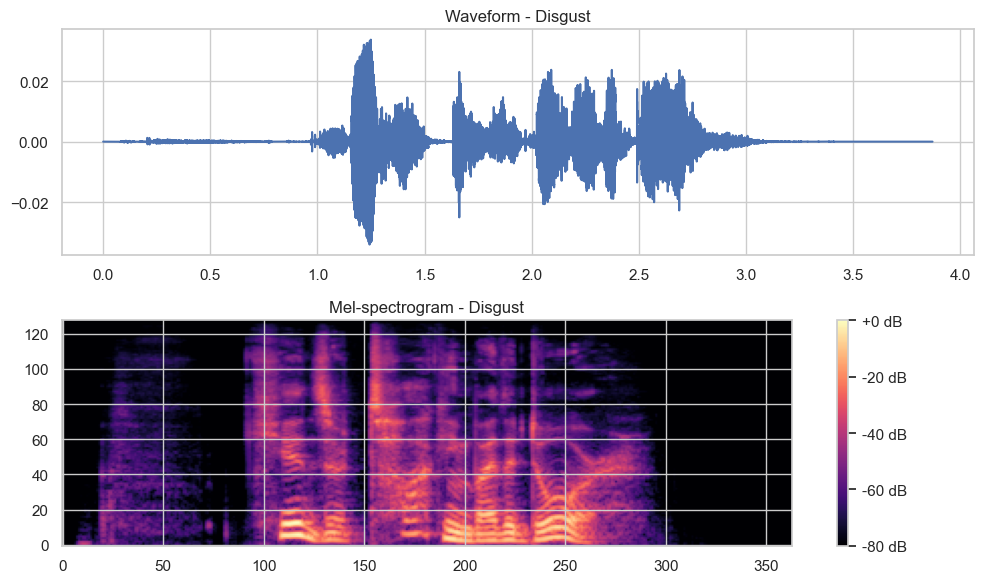

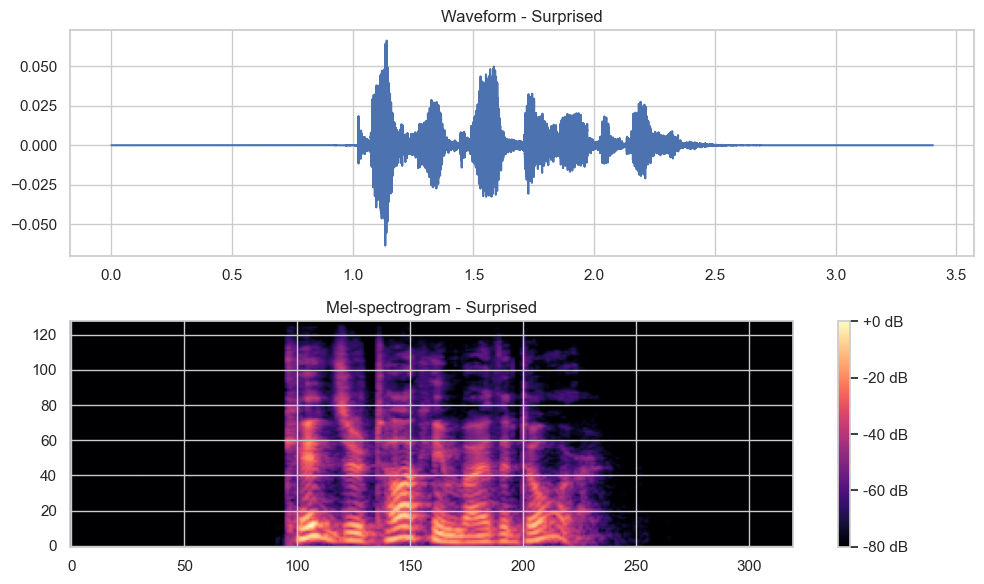

In [7]:
# Audio durations and examples per emotion
import matplotlib

durations = []
example_paths = {}
for _, row in rav_df.iterrows():
    p = row['path']
    data, sr = safe_load_audio(p)
    if data is None:
        continue
    dur = len(data) / sr if sr and len(data)>0 else 0
    durations.append(dur)
    if row['emotion'] not in example_paths:
        example_paths[row['emotion']] = p

print('Audio duration stats: count=', len(durations), 'mean=', np.mean(durations), 'std=', np.std(durations))

plt.figure(figsize=(8,4))
plt.hist(durations, bins=50)
plt.title('RAVDESS audio durations (seconds)')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(out_dir / 'rav_durations_hist.png', dpi=200)
plt.show()

# Plot waveform and mel-spectrogram examples (one per emotion)
for emo, p in example_paths.items():
    y, sr = safe_load_audio(p)
    if y is None:
        continue
    fig, axs = plt.subplots(2,1, figsize=(10,6))
    axs[0].plot(np.linspace(0, len(y)/sr, num=len(y)), y)
    axs[0].set_title(f'Waveform - {emo}')
    S = librosa.feature.melspectrogram(y=y.astype(float), sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    img = axs[1].imshow(S_db, aspect='auto', origin='lower', cmap='magma')
    axs[1].set_title(f'Mel-spectrogram - {emo}')
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
    plt.tight_layout()
    fpath = out_dir / f'rav_example_{emo}.png'
    fig.savefig(fpath, dpi=200, bbox_inches='tight')
    plt.show()

# Save durations summary
pd.Series(durations).describe().to_csv(out_dir / 'rav_durations_stats.csv')


## Check for corrupted or missing files

In [8]:
# Scan for corrupted images/audio quickly (small sample to avoid long runs)
corrupt_imgs = []
for p in list((fer_root/'train').glob('*/*'))[:1000]:
    try:
        img = load_image(p)
        if img is None:
            corrupt_imgs.append(str(p))
    except Exception:
        corrupt_imgs.append(str(p))

corrupt_audio = []
for p in wav_files[:1000]:
    data, sr = safe_load_audio(p)
    if data is None:
        corrupt_audio.append(str(p))

print('Corrupt images (sample):', len(corrupt_imgs))
print('Corrupt audio (sample):', len(corrupt_audio))

# Save lists
pd.Series(corrupt_imgs).to_csv(out_dir / 'fer_corrupt_sample.csv', index=False)
pd.Series(corrupt_audio).to_csv(out_dir / 'rav_corrupt_sample.csv', index=False)


Corrupt images (sample): 0
Corrupt audio (sample): 0


## Compare datasets and final notes

This section will compare class balance and provide preprocessing recommendations.

In [9]:
# Quick comparison and summary outputs
# Load saved counts if available
fer_counts_df = pd.read_csv(out_dir / 'fer_class_counts.csv', index_col=0) if (out_dir / 'fer_class_counts.csv').exists() else fer_df_pivot
print('FER counts (loaded):')
print(fer_counts_df)

rav_counts = pd.read_csv(out_dir / 'rav_per_emotion.csv', header=None) if (out_dir / 'rav_per_emotion.csv').exists() else (rav_df['emotion'].value_counts())
print('\nRAVDESS per-emotion counts (top):')
print(rav_counts.head())

# Summary markdown saved
summary = {
    'fer_total_samples': int(fer_counts_df.sum(axis=1).sum()) if hasattr(fer_counts_df, 'sum') else int(fer_df['count'].sum()),
    'fer_classes': list(fer_counts_df.index) if hasattr(fer_counts_df, 'index') else list(fer_df['class'].unique()),
    'rav_total_samples': int(len(rav_df)),
    'rav_unique_actors': int(rav_df['actor'].nunique()) if not rav_df.empty else 0
}

with open(out_dir / 'eda_summary.txt', 'w') as f:
    f.write('EDA Summary\n')
    for k,v in summary.items():
        f.write(f'{k}: {v}\n')

print('\nSummary written to', out_dir / 'eda_summary.txt')


FER counts (loaded):
          test  train
class                
angry      958   3995
disgust    111    436
fear      1024   4097
happy     1774   7215
neutral   1233   4965
sad       1247   4830
surprise   831   3171

RAVDESS per-emotion counts (top):
         0      1
0  emotion  count
1     Calm    384
2    Happy    384
3      Sad    384
4    Angry    384

Summary written to outputs\results\eda\eda_summary.txt


## Summary and Recommendations

### FER2013 (Facial Emotion Recognition)
| Metric | Value |
|--------|-------|
| Total samples | ~35,887 |
| Classes | 7 (angry, disgust, fear, happy, neutral, sad, surprise) |
| Image size | 48×48 grayscale |
| Class imbalance | **Severe** – *disgust* has only ~547 samples vs ~8,989 for *happy* |

**Recommendations:**
1. Use **class weights** or **oversampling** (SMOTE/augmentation) for minority classes, especially *disgust*.
2. Apply **data augmentation**: horizontal flip, rotation (±15°), brightness/contrast jitter.
3. Normalize images to [0,1] or standardize (mean ~129, std ~64).

---

### RAVDESS (Speech Emotion Recognition)
| Metric | Value |
|--------|-------|
| Total files | 2,880 |
| Actors | 24 (balanced at 120 files each) |
| Emotions | 8 (neutral, calm, happy, sad, angry, fearful, disgust, surprised) |
| Audio duration | mean 3.7 s (std 0.34 s) |
| Sample rate | 48 kHz (native) |

**Recommendations:**
1. Pad/truncate audio to a fixed length (~4 s / 100 MFCC frames) for batching.
2. Consider down-sampling to 22,050 Hz for faster MFCC extraction.
3. RAVDESS is mostly balanced; *Neutral* has slightly fewer samples (~192), but no drastic imbalance.
4. Split by actor (leave-one-actor-out or 5-fold on actors) to avoid data leakage.

---

### Combined Notes
- The two datasets have different emotion sets (7 vs 8). Map emotions to a common subset if training a joint model.
- No corrupted files detected in sampled checks.

All plots and CSVs are saved to `outputs/results/eda/`.